In [1]:
# analyse results and determind how many proteins in pdb database have phrog annotations

** Updated version 2025-04-08*** using mmseqs easy search

In [2]:
# imports 
import pandas as pd
import re
from collections import Counter
import requests
import seaborn as sns
import pickle
from itertools import chain
import matplotlib.pyplot as plt

### Look at the lengths of the PHROG representative sequences 

In [3]:
phrog_lengths = pd.read_csv('/home/grig0076/scratch/phlegm/PHROGs/nonsingleton_representative_sequences.lengths.txt', sep = ' ', header = None)
phrog_lengths[0] = [p[1:] for p in phrog_lengths[0]]

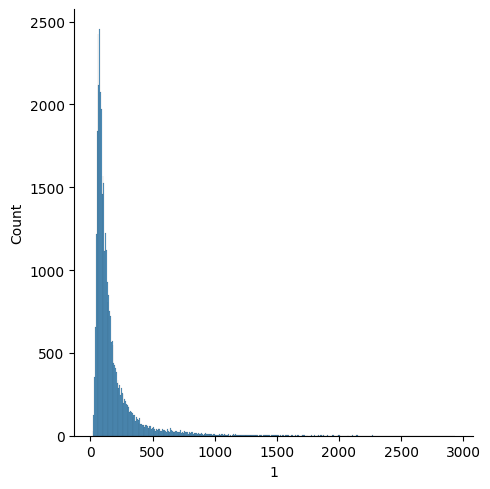

In [4]:
sns.displot(phrog_lengths[1]) # some sequences will be pretty big to fold 

Plot the distribution of the sequence lengths

In [5]:
# read in all the information needing 
oligomer_predictions = pickle.load(open('/home/grig0076/scratch/phlegm/all_pdb/pharokka/pdb_oligomeric_states_mmseqs2_2025-04-08.pkl', 'rb')) 

# add deposition date to the dataframe 
date_dict = dict(zip(oligomer_predictions.keys(), [oligomer_predictions.get(i).get('Deposition_Date') for i in list(oligomer_predictions.keys())]))
states = [str(set([j[0] for j in list(i.get('Assemblies').values())]))[2:-2] for i in oligomer_predictions.values()]
state_dict = dict(zip(oligomer_predictions.keys(), states)) 

In [39]:
from Bio import SeqIO
import pandas as pd

# Load the m8 file
#df = pd.read_csv("/home/grig0076/scratch/phlegm/PHROGs/phrog_represenative_pdb_seqres_minseqid0.3_c0.4.m8", sep="\t", header=None)
df = pd.read_csv("/home/grig0076/scratch/phlegm/PHROGs/phrog_represenative_pdb_seqres_minseqid0.3_c0.7.m8", sep="\t", header=None)
df.columns = [
    "query", "target", "pident", "alnlen", "mismatch", "gapopen",
    "qstart", "qend", "tstart", "tend", "evalue", "bitscore"
]

# Load query and target lengths from FASTA files
def load_lengths(fasta_file):
    return {record.id: len(record.seq) for record in SeqIO.parse(fasta_file, "fasta")}

query_lengths = load_lengths("/home/grig0076/scratch/phlegm/PHROGs/nonsingleton_representative_sequences.fasta")
target_lengths = load_lengths("/home/grig0076/scratch/phlegm/all_pdb/pdb_seqres.cleaned.txt")

# Map lengths to dataframe
df["qlen"] = df["query"].map(query_lengths)
df["tlen"] = df["target"].map(target_lengths)

# Compute coverage
df["query_coverage"] = (df["qend"] - df["qstart"] + 1) / df["qlen"]
df["target_coverage"] = (df["tend"] - df["tstart"] + 1) / df["tlen"]
df['pdb'] = [re.split('_',i)[0] for i in df['target']]

df['Deposition_Date'] = [date_dict.get(i) for i in df['pdb']]
df['oligomeric_state'] = [state_dict.get(i) for i in df['pdb']]

# filter out heteromeric hits 
df = df[~df['oligomeric_state'].str.contains('Hetero')]

#if one entry has two states and one is a monomer then remove the monomer entry 
reformat_states = [] 

for o in df['oligomeric_state']: 
    
    if ',' in o and 'Monomer' in o:
        o = o.replace("Monomer', '", '')
        o = o.replace("', 'Monomer", '')
    reformat_states.append(o)
        
df['oligomeric_state'] = reformat_states

In [7]:
# go through phrog entries to interpret 
phrogs = list(set(df['query']))
oligomeric_rate = pd.DataFrame() 
cutoff_date = pd.Timestamp("2021-09-30", tz="UTC")

counts = 0 
for p in phrogs: 
    
    # get the hits for this phrog
    this_phrog_hits = df[df['query'] == p]
    
    # get the oligomeric states associated with this phrog
    states = this_phrog_hits[['pdb', 'oligomeric_state']].drop_duplicates()['oligomeric_state']
    state_rate = pd.DataFrame.from_dict(Counter(states), orient = 'index')/len(states) 
    state_rate.columns = [p]
    state_rate.loc['_num_assemblies'] = len(states)
    
    # get the deposition dates
    dates = pd.to_datetime(this_phrog_hits['Deposition_Date'], errors='coerce') 
    contains_training = False 
    if (dates < cutoff_date).any():
        contains_training = True
    state_rate.loc['contains_training'] = contains_training
    
    # update the dataframe 
    oligomeric_rate = pd.concat([state_rate, oligomeric_rate], axis=1).fillna(0)
    
    
    #counts+=1
    #if counts ==8: 
        
        # drop duplicates from the same pdb id 
    #    break
    #print(Counter(this_phrog_hits['oligomeric_state']))
    
# update with the predict state and its rate 
oligomeric_rate.loc['best_rate'] = oligomeric_rate.drop(['contains_training', '_num_assemblies']).max(axis=0)
oligomeric_rate.loc['best_state'] = oligomeric_rate.drop(['contains_training', '_num_assemblies']).idxmax(axis=0)
    
# reverse orientation because I like it more 
oligomeric_rate = oligomeric_rate.T

In [10]:
oligomeric_rate

,Homo 2-mer,Monomer,_num_assemblies,contains_training,Homo 3-mer,Homo 9-mer,Homo 4-mer,Homo 28-mer,"Homo 4-mer', 'Homo 2-mer",Homo 16-mer,...,"Homo 2-mer', 'Homo 6-mer', 'Homo 3-mer', 'Homo 9-mer",Homo 120-mer,Homo 360-mer,"Homo 3-mer', 'Homo 9-mer","Homo 14-mer', 'Homo 2-mer","Homo 16-mer', 'Homo 4-mer', 'Homo 8-mer","Homo 2-mer', 'Homo 24-mer","Homo 8-mer', 'Homo 24-mer",best_rate,best_state
phrog_35659,0.769231,0.230769,13.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.769231,Homo 2-mer
phrog_24316,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Homo 2-mer
phrog_2928,0.727273,0.25,44.0,1.0,0.022727,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.727273,Homo 2-mer
phrog_11037,0.0,1.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Monomer
phrog_37043,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Monomer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
phrog_543,0.541667,0.416667,24.0,1.0,0.041667,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.541667,Homo 2-mer
phrog_37114,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Homo 2-mer
phrog_16594,0.24,0.0,50.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.02,0.72,Homo 24-mer
phrog_4581,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Monomer


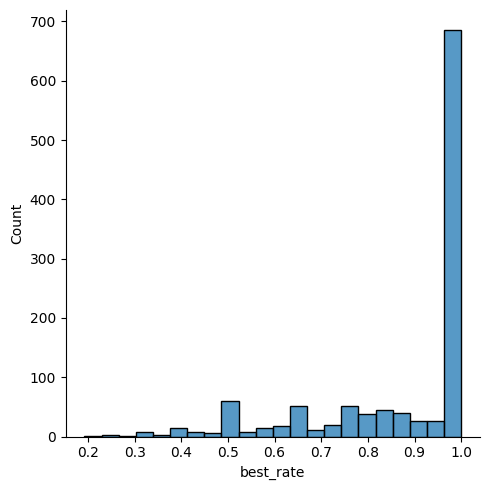

In [11]:
# plot the rates 
sns.displot(oligomeric_rate[oligomeric_rate['contains_training'] == 1]['best_rate']) # this shows that the rate is normally agreed with 

## Phrogs that do not contain training data 

In [12]:
validation_phrogs= oligomeric_rate[oligomeric_rate['contains_training'] == 0]  
validation_phrogs.sort_values('_num_assemblies')

,Homo 2-mer,Monomer,_num_assemblies,contains_training,Homo 3-mer,Homo 9-mer,Homo 4-mer,Homo 28-mer,"Homo 4-mer', 'Homo 2-mer",Homo 16-mer,...,"Homo 2-mer', 'Homo 6-mer', 'Homo 3-mer', 'Homo 9-mer",Homo 120-mer,Homo 360-mer,"Homo 3-mer', 'Homo 9-mer","Homo 14-mer', 'Homo 2-mer","Homo 16-mer', 'Homo 4-mer', 'Homo 8-mer","Homo 2-mer', 'Homo 24-mer","Homo 8-mer', 'Homo 24-mer",best_rate,best_state
phrog_1357,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Homo 9-mer
phrog_12132,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Homo 3-mer
phrog_16914,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Homo 3-mer
phrog_16911,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Monomer
phrog_34130,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Homo 3-mer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
phrog_6215,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Monomer
phrog_7951,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Homo 2-mer
phrog_506,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Monomer
phrog_1048,0.090909,0.090909,11.0,0.0,0.0,0.0,0.818182,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.818182,Homo 4-mer


In [13]:
validation_state_counts = pd.DataFrame.from_dict(Counter(validation_phrogs['best_state']), orient='index')
validation_state_counts_include = validation_state_counts[validation_state_counts.index.isin(['Homo 2-mer', 'Homo 3-mer', 'Monomer', 'Homo 6-mer',
       'Homo 4-mer', 'Homo 9-mer', 'Homo 12-mer',
        'Homo 10-mer',
       'Homo 5-mer', 'Homo 8-mer'])]
validation_state_counts_include

,0
Homo 9-mer,1
Monomer,29
Homo 2-mer,23
Homo 6-mer,8
Homo 3-mer,19
Homo 4-mer,7
Homo 12-mer,7
Homo 5-mer,1
Homo 10-mer,1


In [14]:
# get the phrogs with valid state
validation_phrogs_valid = validation_phrogs[validation_phrogs['best_state'].isin(['Homo 2-mer', 'Homo 3-mer', 'Monomer', 'Homo 6-mer',
       'Homo 4-mer', 'Homo 9-mer', 'Homo 12-mer',
        'Homo 10-mer',
       'Homo 5-mer', 'Homo 8-mer'])]

In [15]:
df[df['query'] == 'phrog_807']

,query,target,pident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bitscore,qlen,tlen,query_coverage,target_coverage,pdb,Deposition_Date,oligomeric_state
47057,phrog_807,8rk8_A,0.957,256,11,0,1,256,1,256,2.266000e-157,492,256,256,1.0,1.0,8rk8,2023-12-23T00:00:00+0000,Homo 6-mer


In [16]:
validation_phrogs_valid[['best_state']].to_csv('validation_phrogs_validstate.csv')

### get the pdbs corresponding to the alphafold validation hits so that their structures can be downloaded 

In [17]:
df[df['query'].isin(validation_phrogs_valid.index)]

,query,target,pident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bitscore,qlen,tlen,query_coverage,target_coverage,pdb,Deposition_Date,oligomeric_state
1121,phrog_22474,8tw1_A,0.417,242,117,0,5,246,8,208,8.804000e-44,167,324,286,0.746914,0.702797,8tw1,2023-08-18T00:00:00+0000,Monomer
1127,phrog_16439,7uyx_A,0.300,162,111,0,13,171,20,181,1.915000e-12,70,194,196,0.819588,0.826531,7uyx,2022-05-07T00:00:00+0000,Homo 2-mer
1128,phrog_16439,7uyx_B,0.300,162,111,0,13,171,20,181,1.915000e-12,70,194,196,0.819588,0.826531,7uyx,2022-05-07T00:00:00+0000,Homo 2-mer
1129,phrog_16439,7uyx_C,0.300,162,111,0,13,171,20,181,1.915000e-12,70,194,196,0.819588,0.826531,7uyx,2022-05-07T00:00:00+0000,Homo 2-mer
1130,phrog_16439,7uyx_D,0.300,162,111,0,13,171,20,181,1.915000e-12,70,194,196,0.819588,0.826531,7uyx,2022-05-07T00:00:00+0000,Homo 2-mer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69113,phrog_31,8xci_J,0.832,1158,190,0,1,1158,1,1131,0.000000e+00,1954,1159,1132,0.999137,0.999117,8xci,2023-12-09T00:00:00+0000,Homo 3-mer
69114,phrog_31,8xci_Z,0.832,1158,190,0,1,1158,1,1131,0.000000e+00,1954,1159,1132,0.999137,0.999117,8xci,2023-12-09T00:00:00+0000,Homo 3-mer
69133,phrog_31,8jvm_F,0.649,157,55,0,867,1023,10,166,2.317000e-50,201,1159,166,0.135462,0.945783,8jvm,2023-06-28T00:00:00+0000,Homo 3-mer
69134,phrog_31,8jvm_J,0.649,157,55,0,867,1023,10,166,2.317000e-50,201,1159,166,0.135462,0.945783,8jvm,2023-06-28T00:00:00+0000,Homo 3-mer


In [18]:
phrog_pdb_entries = df[df['query'].isin(validation_phrogs_valid.index)][['pdb', 'query', 'oligomeric_state']].drop_duplicates()
# can see some of these have duplicate entries 

In [19]:
phrog_pdb_entries.to_csv('alphafold_validation_phrogs_with_state.csv')

## Look at the phrogs with data after before alphafold cutoff because they could be used to select thresholds 

I think the best bet here is to select a subset and then manually curate the subset 


In [32]:
alphafold_trained_phrogs = oligomeric_rate[oligomeric_rate['contains_training'] == 1] 

It looks like there are inconsistencies between the same phrog group - use the pisa dataset to see if I can resolve some of this 

In [43]:
# read in the sequences in pisa 
pisa = pd.read_csv('pdb_data/dbsres.dat', delim_whitespace=True, skiprows=1)
pisa = pisa[['No.', 'sq.A', 'sq.A.1', 'kcal/mol']].reset_index().drop('level_0', axis=1)
pisa.columns = ['PDB_id', 'mmSize', 'Sym. num.', 'ASA sq.A', 'BSA sq.A', 'Delta G kcal/mol' ] 
pisa_mmsize_dict = dict(zip(pisa['PDB_id'],pisa['mmSize']))
pisa_symnum_dict = dict(zip(pisa['PDB_id'],pisa['Sym. num.']))

df['pdb_id'] = [re.split('_', d)[0] for d in df['target']]
df['mmSize'] = [pisa_mmsize_dict.get(d) for d in df['pdb_id']] 
df['Sym. num.'] = [pisa_mmsize_dict.get(d) for d in df['pdb_id']] 

/local/grig0076/2542877/ipykernel_4010593/1602972314.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pisa = pd.read_csv('pdb_data/dbsres.dat', delim_whitespace=True, skiprows=1)


In [52]:
# get structures with pisa estimated oligomeric state that were used in alphafold training
alphafold_training_pisa = df[df['query'].isin(oligomeric_rate[oligomeric_rate['contains_training'] == 1].index)].dropna()
alphafold_training_pisa_phrogs = list(set(alphafold_training_pisa['query'])) 

In [ ]:
# just pick 10 or so for each state? 
# maybe I'm jumping ahead - just see how they compare - maybe no manual curation is needed 

In [90]:
Counter(alphafold_training_pisa[['query', 'oligomeric_state']].drop_duplicates()['oligomeric_state'])
# use the ones that actually finish as the set here 

Counter({'Monomer': 503,
         'Homo 2-mer': 485,
         'Homo 3-mer': 143,
         'Homo 4-mer': 132,
         "Homo 4-mer', 'Homo 2-mer": 86,
         'Homo 6-mer': 68,
         'Homo 8-mer': 21,
         "Homo 6-mer', 'Homo 2-mer": 17,
         'Homo 5-mer': 15,
         "Homo 3-mer', 'Homo 6-mer": 12,
         'Homo 12-mer': 10,
         'Homo 7-mer': 7,
         "Homo 8-mer', 'Homo 4-mer": 6,
         "Homo 3-mer', 'Homo 2-mer": 5,
         "Homo 3-mer', 'Homo 6-mer', 'Homo 2-mer": 5,
         'Homo 10-mer': 5,
         "Homo 8-mer', 'Homo 2-mer": 5,
         "Homo 3-mer', 'Homo 12-mer": 3,
         'Homo 9-mer': 3,
         'Homo 14-mer': 3,
         "Homo 5-mer', 'Homo 10-mer": 3,
         "Homo 14-mer', 'Homo 7-mer": 3,
         'Homo 24-mer': 3,
         "Homo 6-mer', 'Homo 12-mer": 2,
         "Homo 3-mer', 'Homo 4-mer": 2,
         "Homo 8-mer', 'Homo 4-mer', 'Homo 2-mer": 2,
         'Homo 180-mer': 2,
         'Homo 16-mer': 2,
         "Homo 2-mer', 'Homo 6-mer', 'H

In [83]:
for p in alphafold_training_pisa_phrogs[:15]:
    this_phrog = alphafold_training_pisa[alphafold_training_pisa['query'] == p ] 


In [67]:
this_phrog # paper here suggests that this is a crystalisation artifact 

,query,target,pident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,...,qlen,tlen,query_coverage,target_coverage,pdb,Deposition_Date,oligomeric_state,pdb_id,mmSize,Sym. num.
41723,phrog_28865,2fsd_A,0.435,116,64,0,694,809,28,141,...,810,142,0.14321,0.802817,2fsd,2006-01-22T00:00:00+0000,Homo 2-mer,2fsd,1.0,1.0
41724,phrog_28865,2fsd_B,0.435,116,64,0,694,809,28,141,...,810,142,0.14321,0.802817,2fsd,2006-01-22T00:00:00+0000,Homo 2-mer,2fsd,1.0,1.0


In [71]:
this_phrog # pdb says dimer - paper suggests it could be a higher order oligomer 

,query,target,pident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,...,qlen,tlen,query_coverage,target_coverage,pdb,Deposition_Date,oligomeric_state,pdb_id,mmSize,Sym. num.
38801,phrog_38124,2c0n_A,1.0,197,0,0,1,197,1,197,...,197,203,1.0,0.970443,2c0n,2005-09-06T00:00:00+0000,Homo 2-mer,2c0n,4.0,4.0


In [84]:
this_phrog.iloc[:50] # this here is too inconsitent 

,query,target,pident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,...,qlen,tlen,query_coverage,target_coverage,pdb,Deposition_Date,oligomeric_state,pdb_id,mmSize,Sym. num.
29114,phrog_37443,2vsa_A,0.356,832,520,0,38,845,3,834,...,975,841,0.828718,0.989298,2vsa,2008-04-22T00:00:00+0000,Monomer,2vsa,1.0,1.0
29115,phrog_37443,2vse_A,0.356,832,520,0,38,845,3,834,...,975,841,0.828718,0.989298,2vse,2008-04-22T00:00:00+0000,Monomer,2vse,1.0,1.0
29116,phrog_37443,2vse_B,0.356,832,520,0,38,845,3,834,...,975,841,0.828718,0.989298,2vse,2008-04-22T00:00:00+0000,Monomer,2vse,1.0,1.0
29117,phrog_37443,5h6n_A,0.552,244,109,0,38,281,14,257,...,975,275,0.250256,0.887273,5h6n,2016-11-14T00:00:00+0000,Monomer,5h6n,1.0,1.0
29118,phrog_37443,5h6n_B,0.552,244,109,0,38,281,14,257,...,975,275,0.250256,0.887273,5h6n,2016-11-14T00:00:00+0000,Monomer,5h6n,1.0,1.0
29119,phrog_37443,5h6n_C,0.552,244,109,0,38,281,14,257,...,975,275,0.250256,0.887273,5h6n,2016-11-14T00:00:00+0000,Monomer,5h6n,1.0,1.0
29120,phrog_37443,5h6n_D,0.552,244,109,0,38,281,14,257,...,975,275,0.250256,0.887273,5h6n,2016-11-14T00:00:00+0000,Monomer,5h6n,1.0,1.0
29121,phrog_37443,5h6m_B,0.573,224,95,0,38,261,44,266,...,975,271,0.229744,0.822878,5h6m,2016-11-14T00:00:00+0000,Monomer,5h6m,1.0,1.0
29122,phrog_37443,5h6j_A,0.573,224,95,0,38,261,44,266,...,975,271,0.229744,0.822878,5h6j,2016-11-14T00:00:00+0000,Monomer,5h6j,4.0,4.0
29123,phrog_37443,5h6j_B,0.573,224,95,0,38,261,44,266,...,975,271,0.229744,0.822878,5h6j,2016-11-14T00:00:00+0000,Monomer,5h6j,4.0,4.0
